# IT5006 Group Project - FD002

## 1. Load the train data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime

from scipy.stats import skew, kurtosis
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler


In [2]:
col_names = ['unit_id', 'cycle', 'sys1', 'sys2', 'sys3'] + [f"sensor{i}" for i in range(1, 22)]

df = pd.read_csv('data/train_FD002.txt', delim_whitespace=True, header=None, names=col_names)

## 2. Perform basic checks
### Check for null/missing values
For FD002 we don't see null values:

In [3]:
for col in df.columns:
    if(df[col].isnull().any()):
        print("Column ",col," has null value(s).")
        df[col] = df.groupby('unit_id')[col].transform(lambda x: x.fillna(x.mean()))
# df.describe()

### Find missing cycle per unit (if any)
For FD002 we don't see missing cycles in the raw data:

In [4]:
def find_missing_cycles(df):
    missing_cycles = {}
    for unit_id, group in df.groupby('unit_id'):
        actual_cycles = group['cycle'].values
        expected_cycles = list(range(1, group['cycle'].max() + 1))  # Create the expected cycle sequence
        missing = sorted(set(expected_cycles) - set(actual_cycles))  # Compare and find missing cycles
        if missing:
            missing_cycles[unit_id] = missing
    return missing_cycles

missing_cycles = find_missing_cycles(df)
if (len(missing_cycles)):
    print(missing_cycles)

## 3. Add Remaining Useful Life (RUL) as target

In [6]:
df['RUL'] = df.groupby('unit_id')['cycle'].transform(lambda x: x.max() - x).clip(upper=130)
#df

## 4. Explooratory Data Analysis

### Statistical summary

In [7]:
print(df.shape)
pd.set_option('display.max_columns', None)
df.describe()

(53759, 27)


,unit_id,cycle,sys1,sys2,sys3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,RUL
count,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000
mean,131.082981,109.154746,23.998407,0.572056,94.046020,472.910207,579.672399,1419.971013,1205.442024,8.031986,11.600746,282.606787,2228.879188,8525.200837,1.094962,42.985172,266.069034,2334.557253,8066.597682,9.329654,0.023326,348.309511,2228.806358,97.756838,20.789296,12.473423,88.818133
std,74.463862,69.180569,14.747376,0.310016,14.237735,26.389707,37.289399,105.946341,119.123428,3.613839,5.431802,146.005306,145.209816,335.812013,0.127469,3.232372,137.659507,128.068271,84.837950,0.749335,0.004711,27.754515,145.327980,5.364067,9.869331,5.921615,43.438666
min,1.000000,1.000000,0.000000,0.000000,60.000000,445.000000,535.530000,1243.730000,1023.770000,3.910000,5.710000,136.800000,1914.770000,7985.560000,0.930000,36.230000,129.120000,2027.610000,7848.360000,8.335700,0.020000,303.000000,1915.000000,84.930000,10.180000,6.010500,0.000000
25%,68.000000,52.000000,10.004600,0.250700,100.000000,445.000000,549.570000,1352.760000,1123.655000,3.910000,5.720000,139.935000,2211.880000,8321.660000,1.020000,41.910000,131.520000,2387.900000,8062.140000,8.677800,0.020000,331.000000,2212.000000,100.000000,10.910000,6.546300,51.000000
50%,131.000000,104.000000,25.001300,0.700000,100.000000,462.540000,555.980000,1369.180000,1138.890000,7.050000,9.030000,194.660000,2223.070000,8361.200000,1.020000,42.390000,183.200000,2388.080000,8082.540000,9.310900,0.020000,335.000000,2223.000000,100.000000,14.880000,8.929200,103.000000
75%,195.000000,157.000000,41.998000,0.840000,100.000000,491.190000,607.340000,1499.370000,1306.850000,10.520000,15.490000,394.080000,2323.960000,8778.030000,1.260000,45.350000,371.260000,2388.170000,8127.195000,9.386900,0.030000,369.000000,2324.000000,100.000000,28.470000,17.083200,130.000000
max,260.000000,378.000000,42.008000,0.842000,100.000000,518.670000,644.520000,1612.880000,1439.230000,14.620000,21.610000,555.820000,2388.390000,9215.660000,1.300000,48.510000,523.370000,2390.480000,8268.500000,11.066900,0.030000,399.000000,2388.000000,100.000000,39.340000,23.590100,130.000000


### Box plot

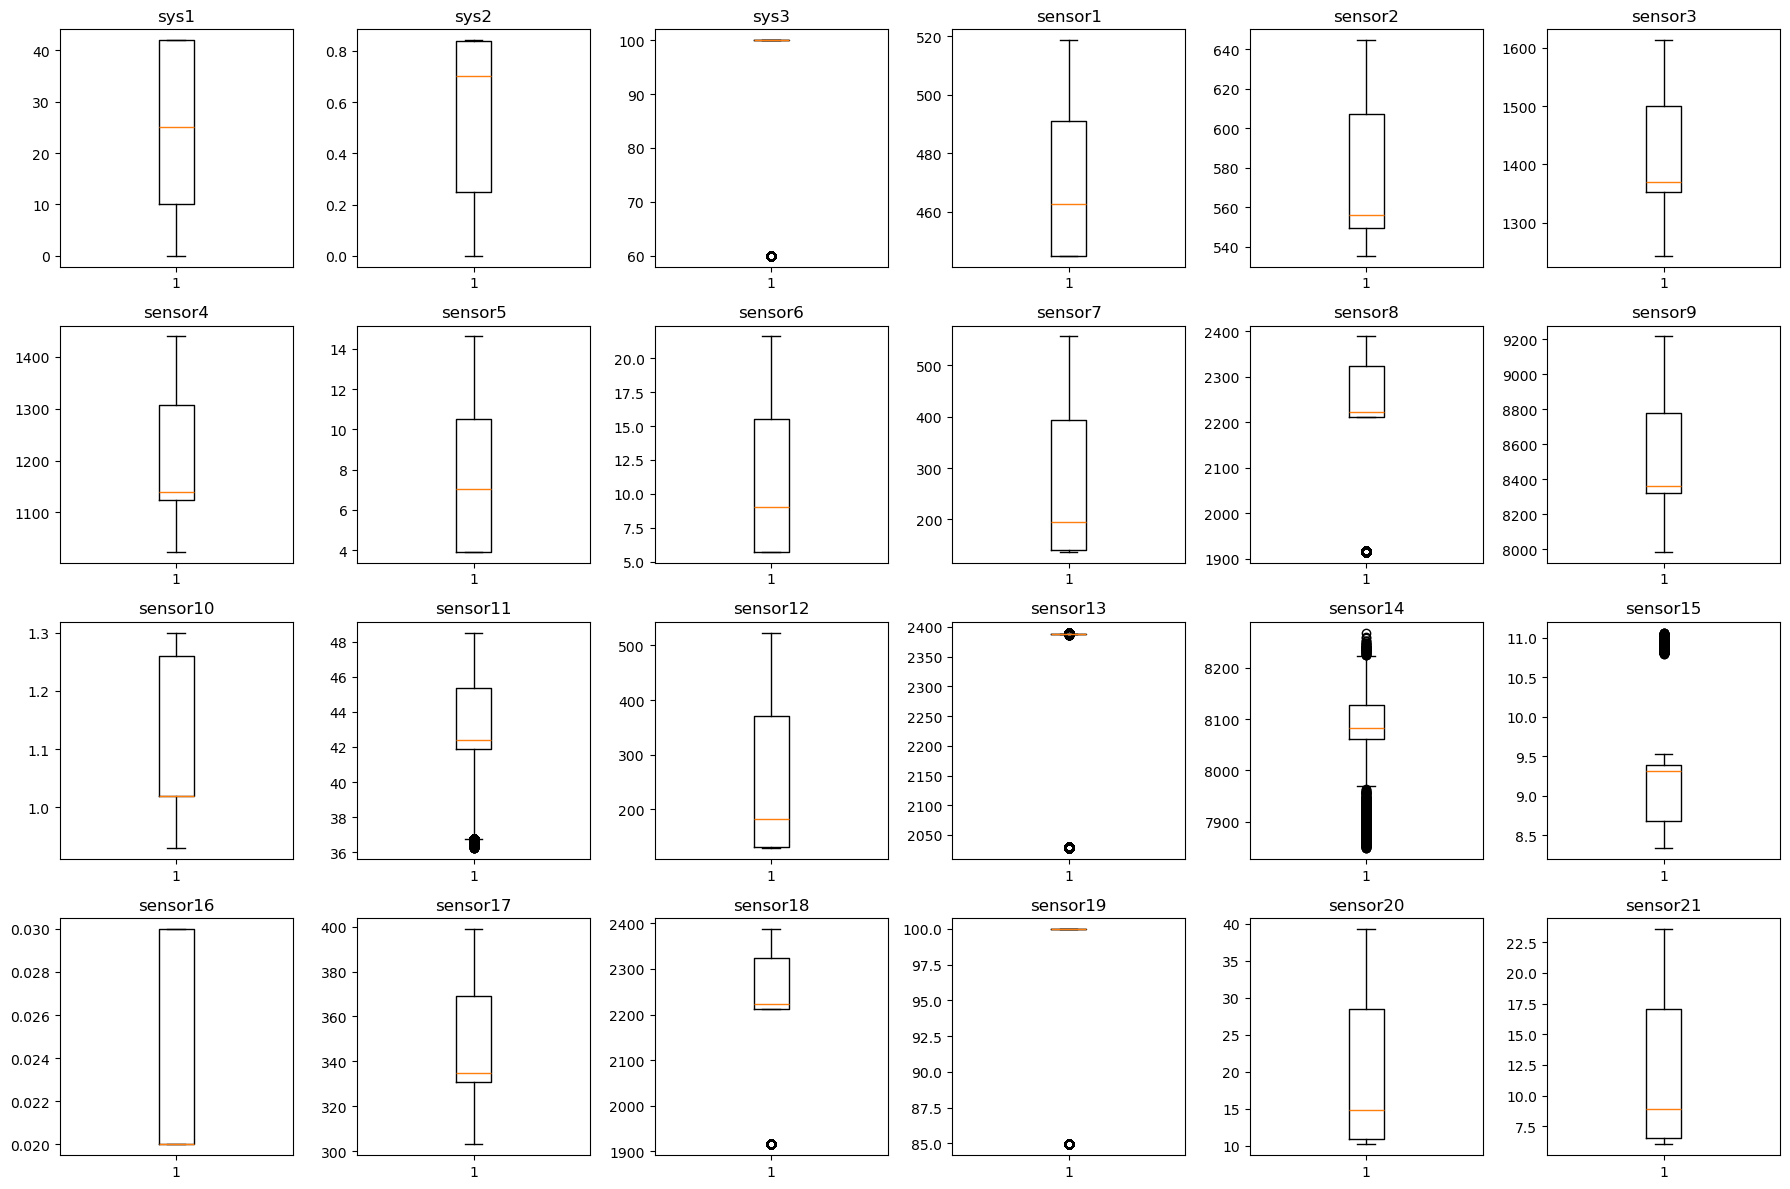

In [9]:
# Create a grid of subplots
unit_id = 1
cols = df.columns
cols = cols[~cols.isin(['unit_id', 'cycle', 'RUL'])]

fig, axes = plt.subplots(4, 6, figsize = (18, 12))
axes = axes.flatten()

for i, col in enumerate(cols):
    axes[i].boxplot(df[col])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

### Count of distinct values per sensor

In [10]:
df[cols].nunique()

sys1          536
sys2          105
sys3            2
sensor1         6
sensor2      1590
sensor3     12305
sensor4     15411
sensor5         6
sensor6        14
sensor7      2067
sensor8       897
sensor9     22434
sensor10        9
sensor11      681
sensor12     1672
sensor13      514
sensor14    14905
sensor15     8464
sensor16        2
sensor17       53
sensor18        6
sensor19        2
sensor20      510
sensor21    17837
dtype: int64

### Crrelation heatmap

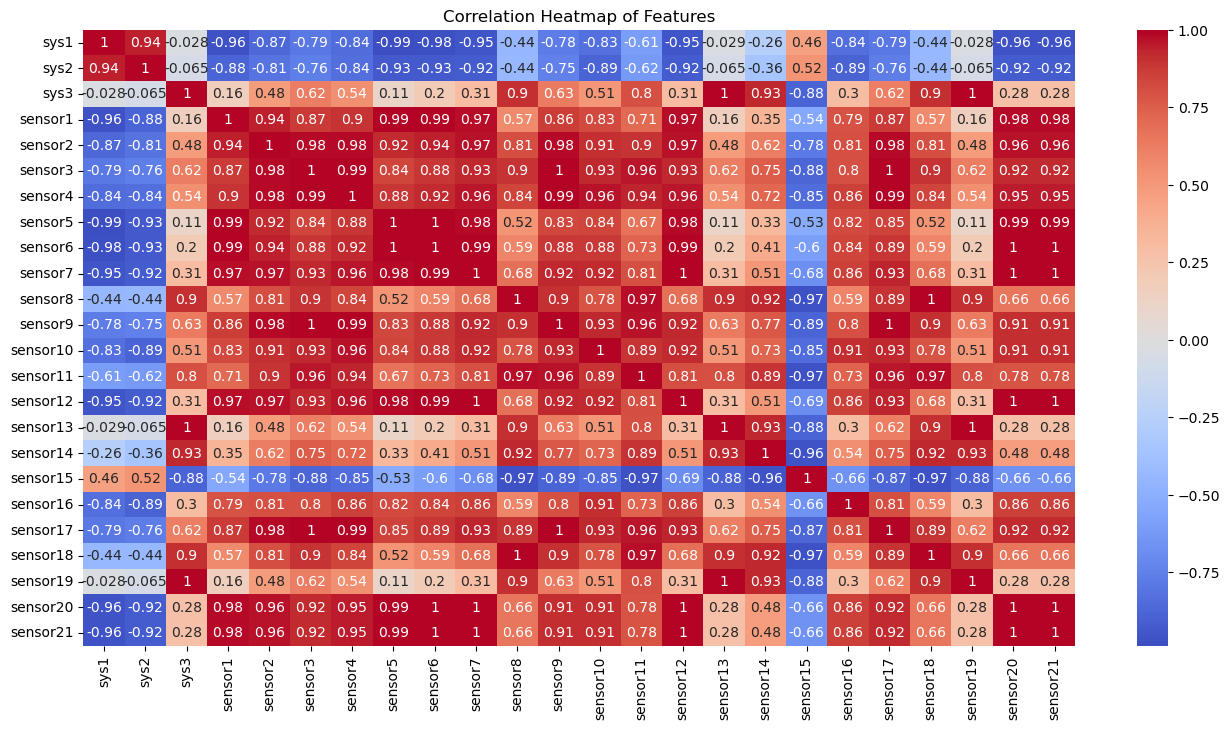

In [11]:
correlation_matrix = df[cols].corr()
plt.figure(figsize=(16, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)

plt.title('Correlation Heatmap of Features')
plt.show()

In [12]:
# Find index pairs with |correlation|>threshold
threshold = 0.99
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

# Convert to DataFrame for a cleaner view if desired
high_corr_df = pd.DataFrame(high_corr_pairs, columns=["Feature 1", "Feature 2", "Correlation"])
high_corr_df

,Feature 1,Feature 2,Correlation
0,sys3,sensor13,0.999998
1,sys3,sensor19,1.000000
2,sensor3,sensor9,0.997806
3,sensor3,sensor17,0.998680
4,sensor4,sensor17,0.990213
5,sensor5,sensor6,0.996311
6,sensor6,sensor7,0.993270
7,sensor6,sensor12,0.993096
8,sensor6,sensor20,0.996356
9,sensor6,sensor21,0.996363


From the correlation heatmap above we can see:

- {sys3, sensor13 and sensor19}
- {sensor3, sensor4, sensor9, sensor17}
- {sensor5, sensor6, sensor7, sensor12, sensor20, sensor21}
- {sensor8, sensor18}

These 4 groups of features are highly correlated. We can consider only keep one per each group.

Here's the correlation heatmap after dropping redandunt columns:

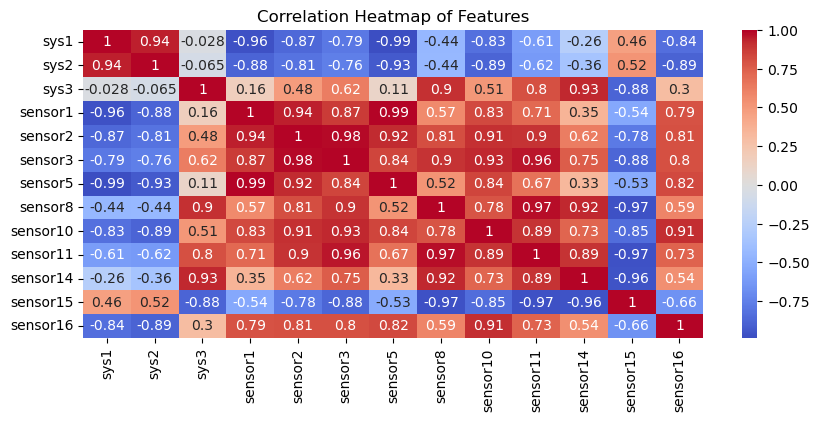

In [13]:
cols_to_drop = ['sensor13', 'sensor19', 'sensor4', 'sensor9', 'sensor17', 'sensor6', 'sensor7', 'sensor12', 'sensor20', 'sensor21', 'sensor18']
df = df.drop(columns=set(cols_to_drop).intersection(df.columns))
cols = cols[~cols.isin(cols_to_drop)]

correlation_matrix = df[cols].corr()
plt.figure(figsize=(10, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)

plt.title('Correlation Heatmap of Features')
plt.show()

### Line plot of one unit

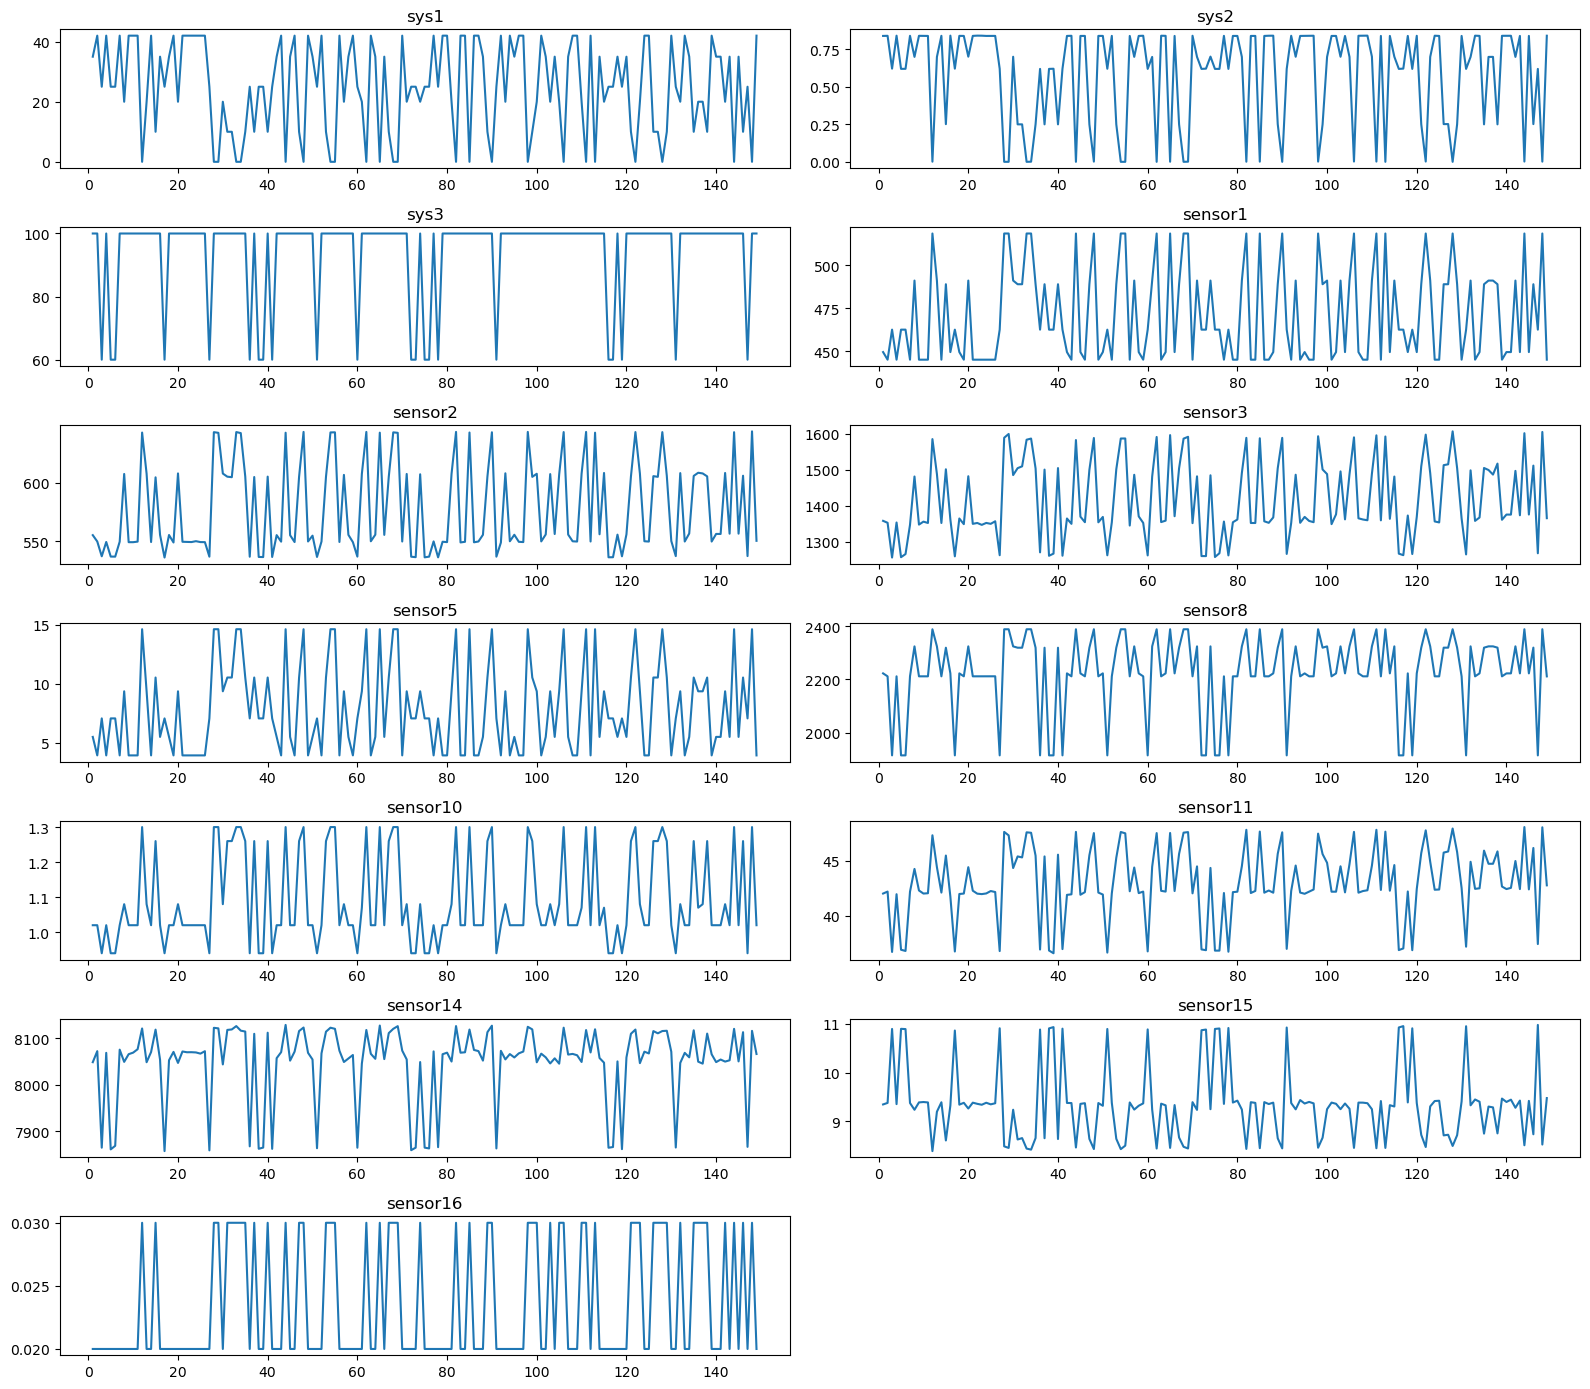

In [14]:
# Create a grid of subplots
unit_id = 1
unit_df = df[df['unit_id'] == unit_id]

fig, axes = plt.subplots(7, 2, figsize = (16, 14))
axes = axes.flatten()

for i, col in enumerate(cols):
    axes[i].plot(unit_df['cycle'], unit_df[col])
    axes[i].set_title(col)

fig.delaxes(axes[13])
plt.tight_layout()
plt.show()

Unlike dataset FD001, we don't see constant or near-constant columns, so we can keep this set of features as our initial features.

## 4. Feature Engineering
### Create new features

In [15]:
def create_features(df, window_size):
    # Initialize new features dataframe
    features = pd.DataFrame()
    features['unit_id'] = df['unit_id']
    features['cycle'] = df['cycle']

    # 1. Static statistical features
    sensor_cols = [col for col in df.columns if col.startswith('sensor')]
    agg_dict = {col: ['mean', 'std', 'min', 'max', 'var', skew, kurtosis] for col in sensor_cols}
    statistical_features = df.groupby('unit_id').agg(agg_dict)
    statistical_features.columns = ['_static_'.join(col) for col in statistical_features.columns]
    features = features.merge(statistical_features, on='unit_id', how='left')

    # 2. Rolling statistical features (using window_size)
    rolling_window = []
    stat_functions = {
        'mean': np.mean,
        'std': np.std,
        'min': np.min,
        'max': np.max,
        'var': np.var,
        'skew': skew,
        'kurtosis': kurtosis
    }
    
    for stat_name, stat_function in stat_functions.items():
        rolling_result = df.groupby('unit_id').rolling(window=window_size, on='cycle')[sensor_cols].apply(stat_function).reset_index()
        rolling_result = rolling_result[sensor_cols]
        rolling_result.columns = [f'{col}_rolling_{stat_name}' for col in sensor_cols]
        rolling_window.append(rolling_result)
    
    rolling_window = pd.concat(rolling_window, axis=1)
    features = pd.concat([features, rolling_window], axis=1)

    # 3. Immediate diff feature
    for col in sensor_cols:
        features[f'{col}_diff'] = df.groupby('unit_id')[col].diff()

    # 4. Rolling trend features
    for col in sensor_cols:
        slopes = []
        for unit_id in df['unit_id'].unique():
            unit_data = df[df['unit_id'] == unit_id]
            for i in range(len(unit_data)):
                if i < window_size - 1:
                    slopes.append(0)
                else:
                    y = unit_data.iloc[i-window_size+1:i+1][col].values
                    x = np.array(range(window_size)).reshape(-1, 1)
                    model = LinearRegression().fit(x, y)
                    slopes.append(model.coef_[0])
        features[f'{col}_rolling_slope'] = slopes

    # 5. Lag features
    lag_values = [5, 10]
    for col in sensor_cols:
        for lag in lag_values:
            features[f'{col}_lag_{lag}'] = df.groupby('unit_id')[col].shift(lag)

    # 6. Rolling lag features
    rolling_lag_values = [5, 10]
    for col in sensor_cols:
        for lag in rolling_lag_values:
            features[f'{col}_rolling_lag_{lag}'] = df.groupby('unit_id')[col].shift(lag).rolling(window=window_size).mean()
                
    df_with_features = pd.concat([df, features.drop(columns=['unit_id', 'cycle']).reset_index(drop=True)], axis=1)
    return df_with_features


def create_temperature_pressure_ratio_features(df, window_size):
    # Create ratios for temperature sensors 1, 2, 3, 4 against pressure sensors 5, 6, 7
    # Due to high correlation, this map reduced to sensors 1, 2, 3 to sensor 5
    sensor_numerators = ['sensor1', 'sensor2', 'sensor3']
    sensor_denominators = ['sensor5']

    for num in sensor_numerators:
        for denom in sensor_denominators:
            df[f'tp_ratio_{num}_to_{denom}'] = df[num] / (df[denom] + 1e-6) # add a small number to avoid division by 0
            df[f'rolling_mean_ratio_{num}_to_{denom}'] = df[f'{num}_rolling_mean'] / (df[f'{denom}_rolling_mean'] + 1e-6)

    return df

In [16]:
window_size = 30
train_df = create_features(df, window_size)
train_df = create_temperature_pressure_ratio_features(train_df, window_size)
train_df.head()

,unit_id,cycle,sys1,sys2,sys3,sensor1,sensor2,sensor3,sensor5,sensor8,sensor10,sensor11,sensor14,sensor15,sensor16,RUL,sensor1_static_mean,sensor1_static_std,sensor1_static_min,sensor1_static_max,sensor1_static_var,sensor1_static_skew,sensor1_static_kurtosis,sensor2_static_mean,sensor2_static_std,sensor2_static_min,sensor2_static_max,sensor2_static_var,sensor2_static_skew,sensor2_static_kurtosis,sensor3_static_mean,sensor3_static_std,sensor3_static_min,sensor3_static_max,sensor3_static_var,sensor3_static_skew,sensor3_static_kurtosis,sensor5_static_mean,sensor5_static_std,sensor5_static_min,sensor5_static_max,sensor5_static_var,sensor5_static_skew,sensor5_static_kurtosis,sensor8_static_mean,sensor8_static_std,sensor8_static_min,sensor8_static_max,sensor8_static_var,sensor8_static_skew,sensor8_static_kurtosis,sensor10_static_mean,sensor10_static_std,sensor10_static_min,sensor10_static_max,sensor10_static_var,sensor10_static_skew,sensor10_static_kurtosis,sensor11_static_mean,sensor11_static_std,sensor11_static_min,sensor11_static_max,sensor11_static_var,sensor11_static_skew,sensor11_static_kurtosis,sensor14_static_mean,sensor14_static_std,sensor14_static_min,sensor14_static_max,sensor14_static_var,sensor14_static_skew,sensor14_static_kurtosis,sensor15_static_mean,sensor15_static_std,sensor15_static_min,sensor15_static_max,sensor15_static_var,sensor15_static_skew,sensor15_static_kurtosis,sensor16_static_mean,sensor16_static_std,sensor16_static_min,sensor16_static_max,sensor16_static_var,sensor16_static_skew,sensor16_static_kurtosis,sensor1_rolling_mean,sensor2_rolling_mean,sensor3_rolling_mean,sensor5_rolling_mean,sensor8_rolling_mean,sensor10_rolling_mean,sensor11_rolling_mean,sensor14_rolling_mean,sensor15_rolling_mean,sensor16_rolling_mean,sensor1_rolling_std,sensor2_rolling_std,sensor3_rolling_std,sensor5_rolling_std,sensor8_rolling_std,sensor10_rolling_std,sensor11_rolling_std,sensor14_rolling_std,sensor15_rolling_std,sensor16_rolling_std,sensor1_rolling_min,sensor2_rolling_min,sensor3_rolling_min,sensor5_rolling_min,sensor8_rolling_min,sensor10_rolling_min,sensor11_rolling_min,sensor14_rolling_min,sensor15_rolling_min,sensor16_rolling_min,sensor1_rolling_max,sensor2_rolling_max,sensor3_rolling_max,sensor5_rolling_max,sensor8_rolling_max,sensor10_rolling_max,sensor11_rolling_max,sensor14_rolling_max,sensor15_rolling_max,sensor16_rolling_max,sensor1_rolling_var,sensor2_rolling_var,sensor3_rolling_var,sensor5_rolling_var,sensor8_rolling_var,sensor10_rolling_var,sensor11_rolling_var,sensor14_rolling_var,sensor15_rolling_var,sensor16_rolling_var,sensor1_rolling_skew,sensor2_rolling_skew,sensor3_rolling_skew,sensor5_rolling_skew,sensor8_rolling_skew,sensor10_rolling_skew,sensor11_rolling_skew,sensor14_rolling_skew,sensor15_rolling_skew,sensor16_rolling_skew,sensor1_rolling_kurtosis,sensor2_rolling_kurtosis,sensor3_rolling_kurtosis,sensor5_rolling_kurtosis,sensor8_rolling_kurtosis,sensor10_rolling_kurtosis,sensor11_rolling_kurtosis,sensor14_rolling_kurtosis,sensor15_rolling_kurtosis,sensor16_rolling_kurtosis,sensor1_diff,sensor2_diff,sensor3_diff,sensor5_diff,sensor8_diff,sensor10_diff,sensor11_diff,sensor14_diff,sensor15_diff,sensor16_diff,sensor1_rolling_slope,sensor2_rolling_slope,sensor3_rolling_slope,sensor5_rolling_slope,sensor8_rolling_slope,sensor10_rolling_slope,sensor11_rolling_slope,sensor14_rolling_slope,sensor15_rolling_slope,sensor16_rolling_slope,sensor1_lag_5,sensor1_lag_10,sensor2_lag_5,sensor2_lag_10,sensor3_lag_5,sensor3_lag_10,sensor5_lag_5,sensor5_lag_10,sensor8_lag_5,sensor8_lag_10,sensor10_lag_5,sensor10_lag_10,sensor11_lag_5,sensor11_lag_10,sensor14_lag_5,sensor14_lag_10,sensor15_lag_5,sensor15_lag_10,sensor16_lag_5,sensor16_lag_10,sensor1_rolling_lag_5,sensor1_rolling_lag_10,sensor2_rolling_lag_5,sensor2_rolling_lag_10,sensor3_rolling_lag_5,sensor3_rolling_lag_10,sensor5_rolling_lag_5,sensor5_rolling_lag_10,sensor8_rolling_lag_5,sensor8_rolling_lag_10,sensor10_rolling_lag_5,sensor10_rolling_lag_10,sensor11_

### Pre-processing all features

In [18]:
# Handle missing values by replacing infinite values and dropping NaNs
train_df = train_df.replace([np.inf, -np.inf], np.nan).dropna()
train_df = train_df.apply(pd.to_numeric, errors='coerce').dropna()

train_df_features = train_df.drop(columns=['unit_id','cycle','RUL'])
train_df_seq = train_df[['unit_id','cycle']]
train_df_target = train_df['RUL']

# Min-Max scaling
scaler = MinMaxScaler()
scaler.fit(train_df_features)

train_df_features_scaled = pd.DataFrame(scaler.fit_transform(train_df_features), columns=train_df_features.columns, index=train_df_features.index)
train_df_scaled = pd.concat([train_df_seq, train_df_features_scaled, train_df_target], axis=1)

train_df_scaled.describe()

,unit_id,cycle,sys1,sys2,sys3,sensor1,sensor2,sensor3,sensor5,sensor8,sensor10,sensor11,sensor14,sensor15,sensor16,sensor1_static_mean,sensor1_static_std,sensor1_static_min,sensor1_static_max,sensor1_static_var,sensor1_static_skew,sensor1_static_kurtosis,sensor2_static_mean,sensor2_static_std,sensor2_static_min,sensor2_static_max,sensor2_static_var,sensor2_static_skew,sensor2_static_kurtosis,sensor3_static_mean,sensor3_static_std,sensor3_static_min,sensor3_static_max,sensor3_static_var,sensor3_static_skew,sensor3_static_kurtosis,sensor5_static_mean,sensor5_static_std,sensor5_static_min,sensor5_static_max,sensor5_static_var,sensor5_static_skew,sensor5_static_kurtosis,sensor8_static_mean,sensor8_static_std,sensor8_static_min,sensor8_static_max,sensor8_static_var,sensor8_static_skew,sensor8_static_kurtosis,sensor10_static_mean,sensor10_static_std,sensor10_static_min,sensor10_static_max,sensor10_static_var,sensor10_static_skew,sensor10_static_kurtosis,sensor11_static_mean,sensor11_static_std,sensor11_static_min,sensor11_static_max,sensor11_static_var,sensor11_static_skew,sensor11_static_kurtosis,sensor14_static_mean,sensor14_static_std,sensor14_static_min,sensor14_static_max,sensor14_static_var,sensor14_static_skew,sensor14_static_kurtosis,sensor15_static_mean,sensor15_static_std,sensor15_static_min,sensor15_static_max,sensor15_static_var,sensor15_static_skew,sensor15_static_kurtosis,sensor16_static_mean,sensor16_static_std,sensor16_static_min,sensor16_static_max,sensor16_static_var,sensor16_static_skew,sensor16_static_kurtosis,sensor1_rolling_mean,sensor2_rolling_mean,sensor3_rolling_mean,sensor5_rolling_mean,sensor8_rolling_mean,sensor10_rolling_mean,sensor11_rolling_mean,sensor14_rolling_mean,sensor15_rolling_mean,sensor16_rolling_mean,sensor1_rolling_std,sensor2_rolling_std,sensor3_rolling_std,sensor5_rolling_std,sensor8_rolling_std,sensor10_rolling_std,sensor11_rolling_std,sensor14_rolling_std,sensor15_rolling_std,sensor16_rolling_std,sensor1_rolling_min,sensor2_rolling_min,sensor3_rolling_min,sensor5_rolling_min,sensor8_rolling_min,sensor10_rolling_min,sensor11_rolling_min,sensor14_rolling_min,sensor15_rolling_min,sensor16_rolling_min,sensor1_rolling_max,sensor2_rolling_max,sensor3_rolling_max,sensor5_rolling_max,sensor8_rolling_max,sensor10_rolling_max,sensor11_rolling_max,sensor14_rolling_max,sensor15_rolling_max,sensor16_rolling_max,sensor1_rolling_var,sensor2_rolling_var,sensor3_rolling_var,sensor5_rolling_var,sensor8_rolling_var,sensor10_rolling_var,sensor11_rolling_var,sensor14_rolling_var,sensor15_rolling_var,sensor16_rolling_var,sensor1_rolling_skew,sensor2_rolling_skew,sensor3_rolling_skew,sensor5_rolling_skew,sensor8_rolling_skew,sensor10_rolling_skew,sensor11_rolling_skew,sensor14_rolling_skew,sensor15_rolling_skew,sensor16_rolling_skew,sensor1_rolling_kurtosis,sensor2_rolling_kurtosis,sensor3_rolling_kurtosis,sensor5_rolling_kurtosis,sensor8_rolling_kurtosis,sensor10_rolling_kurtosis,sensor11_rolling_kurtosis,sensor14_rolling_kurtosis,sensor15_rolling_kurtosis,sensor16_rolling_kurtosis,sensor1_diff,sensor2_diff,sensor3_diff,sensor5_diff,sensor8_diff,sensor10_diff,sensor11_diff,sensor14_diff,sensor15_diff,sensor16_diff,sensor1_rolling_slope,sensor2_rolling_slope,sensor3_rolling_slope,sensor5_rolling_slope,sensor8_rolling_slope,sensor10_rolling_slope,sensor11_rolling_slope,sensor14_rolling_slope,sensor15_rolling_slope,sensor16_rolling_slope,sensor1_lag_5,sensor1_lag_10,sensor2_lag_5,sensor2_lag_10,sensor3_lag_5,sensor3_lag_10,sensor5_lag_5,sensor5_lag_10,sensor8_lag_5,sensor8_lag_10,sensor10_lag_5,sensor10_lag_10,sensor11_lag_5,sensor11_lag_10,sensor14_lag_5,sensor14_lag_10,sensor15_lag_5,sensor15_lag_10,sensor16_lag_5,sensor16_lag_10,sensor1_rolling_lag_5,sensor1_rolling_lag_10,sensor2_rolling_lag_5,sensor2_rolling_lag_10,sensor3_rolling_lag_5,sensor3_rolling_lag_10,sensor5_rolling_lag_5,sensor5_rolling_lag_10,sensor8_rolling_lag_5,sensor8_rolling_lag_10,sensor10_rolling_lag_5,sensor10_rolling_lag_10,sensor11_roll

## 5. Apply the same steps to test data set
### Prepare X_test (test_FD002.txt)

In [21]:
test_df = pd.read_csv('data/test_FD002.txt', delim_whitespace=True, header=None, names=col_names)
test_df.drop(columns=set(cols_to_drop).intersection(test_df.columns), inplace=True)

window_size = 30
test_df = create_features(test_df, window_size)
test_df = create_temperature_pressure_ratio_features(test_df, window_size)

test_df = test_df.replace([np.inf, -np.inf], np.nan).dropna()
test_df = test_df.apply(pd.to_numeric, errors='coerce').dropna()

In [24]:
test_df_features = test_df.drop(columns=['unit_id','cycle'])
test_df_seq = test_df[['unit_id','cycle']]

# Reuse the min-max scaler fitted using training data to scale the test data
test_df_features_scaled = pd.DataFrame(scaler.fit_transform(test_df_features), columns=test_df_features.columns, index=test_df_features.index)
test_df_scaled = pd.concat([test_df_seq, test_df_features_scaled], axis=1)

# This is our X_test
test_df_scaled.describe()

,unit_id,cycle,sys1,sys2,sys3,sensor1,sensor2,sensor3,sensor5,sensor8,sensor10,sensor11,sensor14,sensor15,sensor16,sensor1_static_mean,sensor1_static_std,sensor1_static_min,sensor1_static_max,sensor1_static_var,sensor1_static_skew,sensor1_static_kurtosis,sensor2_static_mean,sensor2_static_std,sensor2_static_min,sensor2_static_max,sensor2_static_var,sensor2_static_skew,sensor2_static_kurtosis,sensor3_static_mean,sensor3_static_std,sensor3_static_min,sensor3_static_max,sensor3_static_var,sensor3_static_skew,sensor3_static_kurtosis,sensor5_static_mean,sensor5_static_std,sensor5_static_min,sensor5_static_max,sensor5_static_var,sensor5_static_skew,sensor5_static_kurtosis,sensor8_static_mean,sensor8_static_std,sensor8_static_min,sensor8_static_max,sensor8_static_var,sensor8_static_skew,sensor8_static_kurtosis,sensor10_static_mean,sensor10_static_std,sensor10_static_min,sensor10_static_max,sensor10_static_var,sensor10_static_skew,sensor10_static_kurtosis,sensor11_static_mean,sensor11_static_std,sensor11_static_min,sensor11_static_max,sensor11_static_var,sensor11_static_skew,sensor11_static_kurtosis,sensor14_static_mean,sensor14_static_std,sensor14_static_min,sensor14_static_max,sensor14_static_var,sensor14_static_skew,sensor14_static_kurtosis,sensor15_static_mean,sensor15_static_std,sensor15_static_min,sensor15_static_max,sensor15_static_var,sensor15_static_skew,sensor15_static_kurtosis,sensor16_static_mean,sensor16_static_std,sensor16_static_min,sensor16_static_max,sensor16_static_var,sensor16_static_skew,sensor16_static_kurtosis,sensor1_rolling_mean,sensor2_rolling_mean,sensor3_rolling_mean,sensor5_rolling_mean,sensor8_rolling_mean,sensor10_rolling_mean,sensor11_rolling_mean,sensor14_rolling_mean,sensor15_rolling_mean,sensor16_rolling_mean,sensor1_rolling_std,sensor2_rolling_std,sensor3_rolling_std,sensor5_rolling_std,sensor8_rolling_std,sensor10_rolling_std,sensor11_rolling_std,sensor14_rolling_std,sensor15_rolling_std,sensor16_rolling_std,sensor1_rolling_min,sensor2_rolling_min,sensor3_rolling_min,sensor5_rolling_min,sensor8_rolling_min,sensor10_rolling_min,sensor11_rolling_min,sensor14_rolling_min,sensor15_rolling_min,sensor16_rolling_min,sensor1_rolling_max,sensor2_rolling_max,sensor3_rolling_max,sensor5_rolling_max,sensor8_rolling_max,sensor10_rolling_max,sensor11_rolling_max,sensor14_rolling_max,sensor15_rolling_max,sensor16_rolling_max,sensor1_rolling_var,sensor2_rolling_var,sensor3_rolling_var,sensor5_rolling_var,sensor8_rolling_var,sensor10_rolling_var,sensor11_rolling_var,sensor14_rolling_var,sensor15_rolling_var,sensor16_rolling_var,sensor1_rolling_skew,sensor2_rolling_skew,sensor3_rolling_skew,sensor5_rolling_skew,sensor8_rolling_skew,sensor10_rolling_skew,sensor11_rolling_skew,sensor14_rolling_skew,sensor15_rolling_skew,sensor16_rolling_skew,sensor1_rolling_kurtosis,sensor2_rolling_kurtosis,sensor3_rolling_kurtosis,sensor5_rolling_kurtosis,sensor8_rolling_kurtosis,sensor10_rolling_kurtosis,sensor11_rolling_kurtosis,sensor14_rolling_kurtosis,sensor15_rolling_kurtosis,sensor16_rolling_kurtosis,sensor1_diff,sensor2_diff,sensor3_diff,sensor5_diff,sensor8_diff,sensor10_diff,sensor11_diff,sensor14_diff,sensor15_diff,sensor16_diff,sensor1_rolling_slope,sensor2_rolling_slope,sensor3_rolling_slope,sensor5_rolling_slope,sensor8_rolling_slope,sensor10_rolling_slope,sensor11_rolling_slope,sensor14_rolling_slope,sensor15_rolling_slope,sensor16_rolling_slope,sensor1_lag_5,sensor1_lag_10,sensor2_lag_5,sensor2_lag_10,sensor3_lag_5,sensor3_lag_10,sensor5_lag_5,sensor5_lag_10,sensor8_lag_5,sensor8_lag_10,sensor10_lag_5,sensor10_lag_10,sensor11_lag_5,sensor11_lag_10,sensor14_lag_5,sensor14_lag_10,sensor15_lag_5,sensor15_lag_10,sensor16_lag_5,sensor16_lag_10,sensor1_rolling_lag_5,sensor1_rolling_lag_10,sensor2_rolling_lag_5,sensor2_rolling_lag_10,sensor3_rolling_lag_5,sensor3_rolling_lag_10,sensor5_rolling_lag_5,sensor5_rolling_lag_10,sensor8_rolling_lag_5,sensor8_rolling_lag_10,sensor10_rolling_lag_5,sensor10_rolling_lag_10,sensor11_roll

### Prepare y_test (RUL_FD002.txt)

In [25]:
RUL_df = pd.read_csv('data/RUL_FD002.txt', delim_whitespace=True, header=None, names=['RUL'])
RUL_df['unit_id'] = range(1, len(RUL_df) + 1)

## 5. Build ramdom forest model using all features

In [31]:
from sklearn.model_selection import train_test_split,GridSearchCV,TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def fit_model(X, y, model, param_grid):
    # Set up TimeSeriesSplit for time-series cross-validation
    tscv = TimeSeriesSplit(n_splits=3)
    
    # Perform Grid Search
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, 
                               scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
    grid_search.fit(X, y)
    return grid_search

def get_best_rmse(model):
    y_pred = model.predict(X_test)
    y_pred_df = pd.DataFrame({'unit_id': test_df_scaled['unit_id'].values, 'RUL_pred': y_pred}).groupby('unit_id').tail(1)
    res_df = pd.merge(y_pred_df, RUL_df, on='unit_id', how='left')
    
    mse = mean_squared_error(res_df['RUL'], res_df['RUL_pred'])
    rmse = np.sqrt(mse)
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    return res_df

def plot_feature_importances(model, cols, n):
    feature_importance = model.feature_importances_
    indices = np.argsort(feature_importance)[::-1][:n]

    top_features = feature_importance[indices]
    top_feature_names = cols[indices]

    plt.figure(figsize=(8, 4))
    plt.title(f"Top {n} Feature Importances")
    plt.barh(top_feature_names, top_features, color="blue", align="center")
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature Name")
    plt.gca().invert_yaxis()
    plt.show()


### Evaluate model and plot feature importances

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 200}
Root Mean Squared Error (RMSE): 51.59572812699971


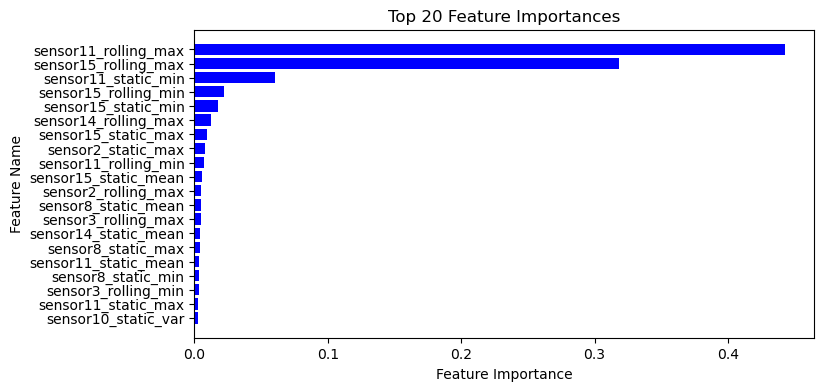

In [32]:
# Select features and target
X_train = train_df_scaled.drop(columns=['RUL', 'unit_id', 'cycle'])
y_train = train_df_scaled['RUL'] # Note: RUL is not scaled
X_test = test_df_scaled.drop(columns=['unit_id', 'cycle'])
y_test = RUL_df['RUL']

rf_model = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [6, 7, 8],
    'min_samples_split': [3, 4, 5],
    'min_samples_leaf': [2, 3, 4]
}

grid_search_rf = fit_model(X_train, y_train, rf_model, param_grid)

# Best parameters
print(f'Best Parameters: {grid_search_rf.best_params_}')

best_rf_model = grid_search_rf.best_estimator_

# Make predictions
rf_res_df = get_best_rmse(best_rf_model)

plot_feature_importances(best_rf_model, X_train.columns, 20)

## 6. Build LightGBM model using all features

In [ ]:
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(verbose=-1)

param_grid_lgb = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [4, 5, 6, 7],
    'num_leaves': [20, 25, 30]
}

grid_search_lgb = fit_model(X_train, y_train, lgb_model, param_grid_lgb)

# Best parameters
print(f'Best Parameters: {grid_search_lgb.best_params_}')

best_lgb_model = grid_search_lgb.best_estimator_

# Make predictions
lgb_res_df = get_best_rmse(best_lgb_model)

plot_feature_importances(best_rf_model, X_train.columns, 20)

Fitting 3 folds for each of 192 candidates, totalling 576 fits
